# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [106]:
p1 = 0.8
p2 = 0.2
entropy = - (p1 * np.log(p1) + p2 * np.log(p2))
print(f"Энтропия: {entropy:.2f}")

Энтропия: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [107]:
H_Rm = 0.8 * (1 - 0.8) + 0.2 * (1 - 0.2)
H_Rl = 0
H_Rr = 0
Q = H_Rm - (8/10) * H_Rl - (2/10) * H_Rr
print(f"Критерий информативности: {Q:.2f}")

Критерий информативности: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [108]:
y = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
prediction = np.mean(y)
print(f"Предсказание: {prediction:.2f}")

Предсказание: 40.60


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [109]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [110]:
def optimal_split(
    feature_values: Union[np.ndarray, pd.DataFrame],
    labels: Union[np.ndarray, pd.Series],
    task_type: str = "classification",
    feature_kind: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Находит оптимальный порог для разделения данных на основе признака.

    :param feature_values: Вектор значений признака
    :param labels: Вектор целевых значений, длина совпадает с feature_values
    :param task_type: 'classification' или 'regression'
    :param feature_kind: 'real' или 'categorical'
    :return: (пороги, значения критерия, лучший порог, лучшее значение критерия)
    """
    if len(np.unique(feature_values)) <= 1:
        return np.array([]), np.array([]), None, float('-inf')

    indices = np.argsort(feature_values)
    sorted_features = feature_values[indices]
    sorted_labels = labels[indices]

    if feature_kind == "real":
        unique_features = np.unique(sorted_features)
        split_points = (unique_features[:-1] + unique_features[1:]) / 2
    else:
        split_points = np.unique(sorted_features)

    valid_splits = []
    quality_scores = []

    best_score = float('-inf')
    optimal_split = None

    for split in split_points:
        mask_left = sorted_features < split if feature_kind == "real" else sorted_features == split
        mask_right = ~mask_left

        if not (mask_left.any() and mask_right.any()):
            continue

        n_left, n_right = mask_left.sum(), mask_right.sum()
        n_total = n_left + n_right

        if task_type == "classification":
            def compute_gini(y):
                if not y.size:
                    return 0
                proportions = np.bincount(y) / y.size
                return 1 - np.sum(proportions ** 2)

            parent_score = compute_gini(sorted_labels)
            left_score = compute_gini(sorted_labels[mask_left])
            right_score = compute_gini(sorted_labels[mask_right])

            score = parent_score - (n_left / n_total) * left_score - (n_right / n_total) * right_score
        else:
            parent_var = np.var(sorted_labels)
            left_var = np.var(sorted_labels[mask_left]) if mask_left.any() else 0
            right_var = np.var(sorted_labels[mask_right]) if mask_right.any() else 0

            score = parent_var - (n_left / n_total) * left_var - (n_right / n_total) * right_var

        valid_splits.append(split)
        quality_scores.append(score)

        if score > best_score or (score == best_score and (optimal_split is None or split < optimal_split)):
            best_score = score
            optimal_split = split

    return np.array(valid_splits), np.array(quality_scores), optimal_split, best_score

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [111]:
!pip3 install scikit-learn

In [112]:
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data
y = boston.target

print(boston.DESCR)
X.head()

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

Лучший порог: 6.69
Наилучшее значение критерия (уменьшение дисперсии): 16.3363


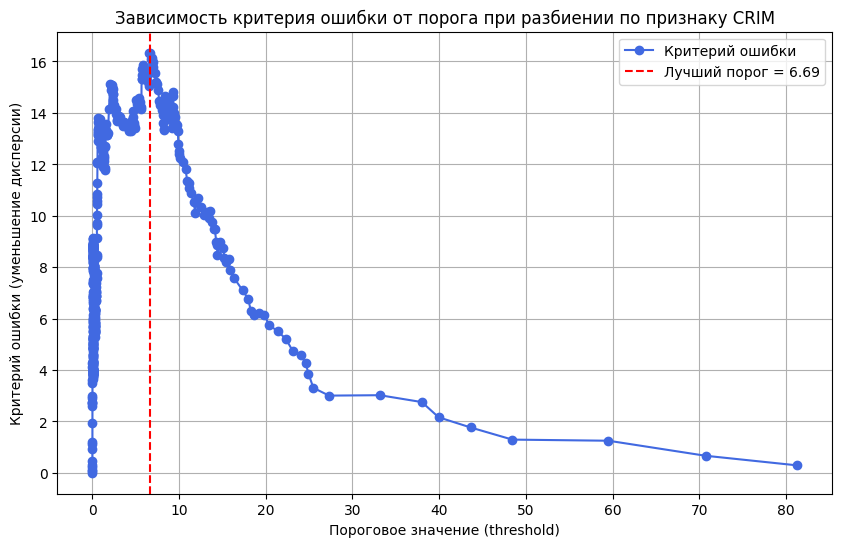

In [113]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(),
    y.to_numpy(),
    task="regression",
    feature_type="real"
)

print(f"Лучший порог: {threshold_best:.2f}")
print(f"Наилучшее значение критерия (уменьшение дисперсии): {variance_best:.4f}")

plt.figure(figsize=(10, 6))
if thresholds.size > 0:
    plt.plot(thresholds, variances, marker='o', linestyle='-', color='royalblue', label="Критерий ошибки")
    plt.axvline(threshold_best, color='red', linestyle='--', label=f"Лучший порог = {threshold_best:.2f}")
else:
    print("График не построен: нет допустимых порогов для разбиения.")
plt.title("Зависимость критерия ошибки от порога при разбиении по признаку CRIM")
plt.xlabel("Пороговое значение (threshold)")
plt.ylabel("Критерий ошибки (уменьшение дисперсии)")
plt.legend()
plt.grid(True)
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [114]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")
        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
          return node["class"]

        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
          if x[feature] <= node["threshold"]:
            return self._predict_node(x, node["left_child"])
          else:
            return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature] == "categorical":
          if x[feature] == node["category_split"]:
            return self._predict_node(x, node["left_child"])
          else:
            return self._predict_node(x, node["right_child"])
        else:
          raise ValueError("Unknown feature type")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

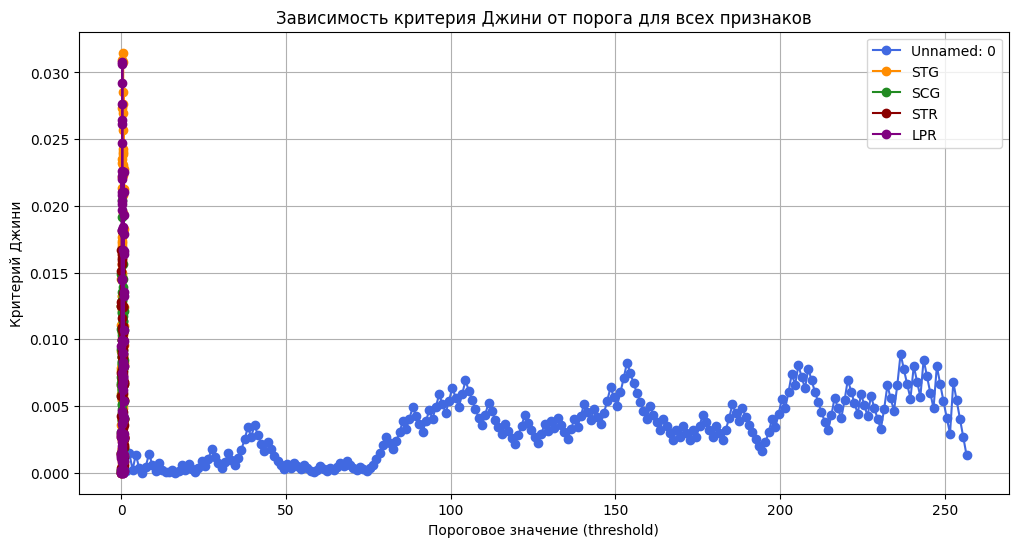

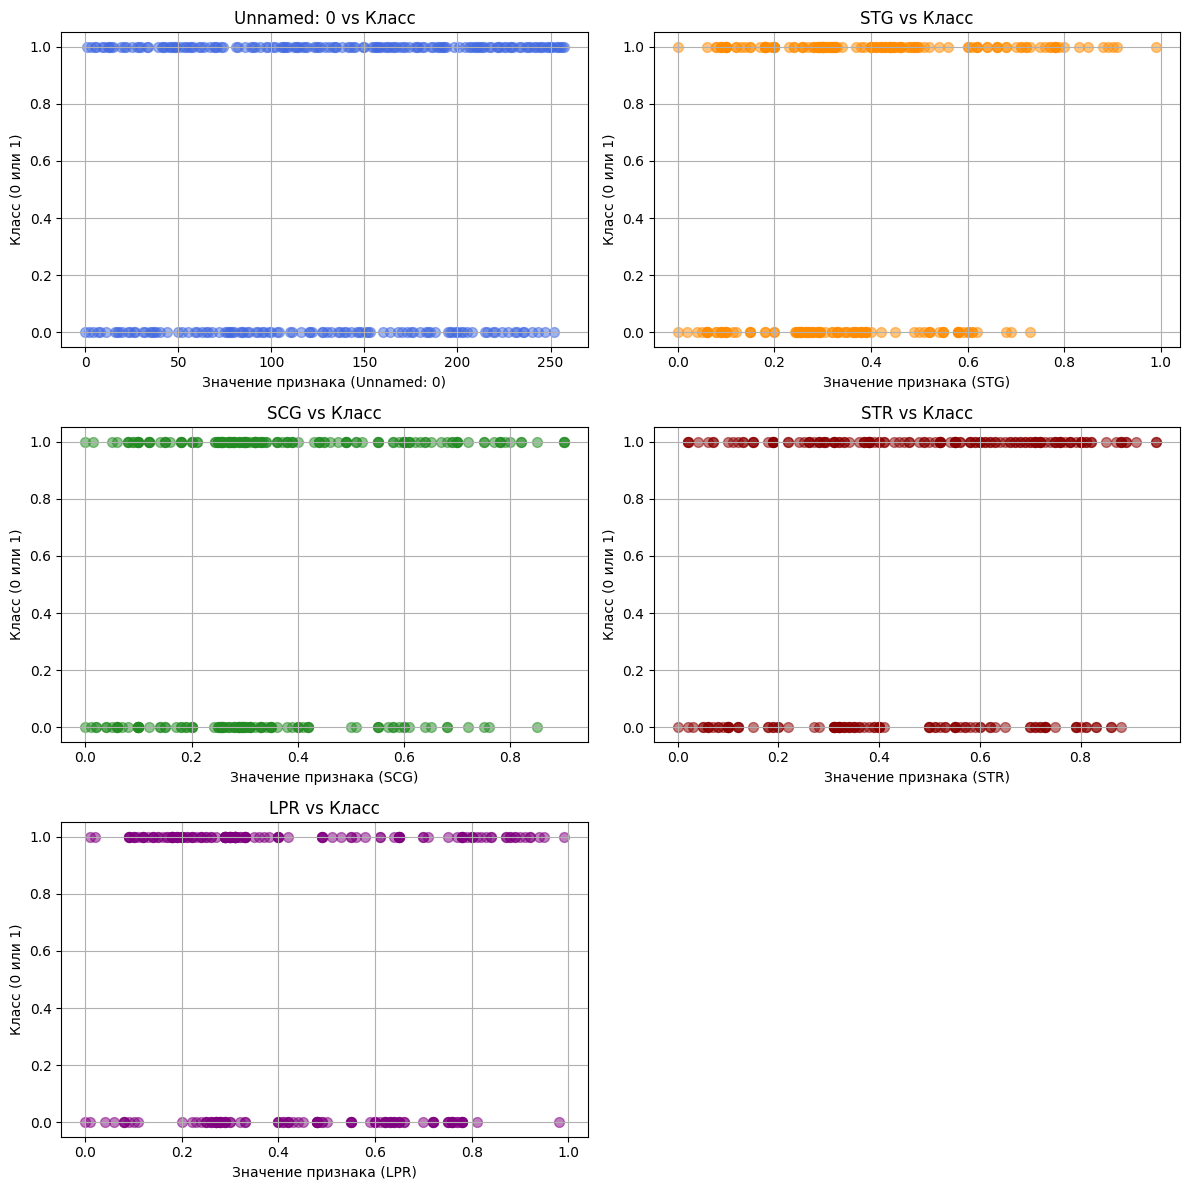

In [115]:
data = pd.read_csv("students.csv")

features = data.iloc[:, :5].columns
X = data.iloc[:, :5].to_numpy()
y = data.iloc[:, -1].to_numpy()

colors = ['royalblue', 'darkorange', 'forestgreen', 'darkred', 'purple']
feature_names = features.tolist()

plt.figure(figsize=(12, 6))
for i, (feature, color) in enumerate(zip(features, colors)):
    thresholds, ginis, threshold_best, gini_best = find_best_split(
        X[:, i],
        y,
        task="classification",
        feature_type="real"
    )

    if thresholds.size > 0:
        plt.plot(thresholds, ginis, marker='o', linestyle='-', color=color,
                 label=f"{feature}")
    else:
        print(f"Признак {feature} не имеет допустимых порогов для разбиения.")

plt.title("Зависимость критерия Джини от порога для всех признаков")
plt.xlabel("Пороговое значение (threshold)")
plt.ylabel("Критерий Джини")
plt.legend()
plt.grid(True)
plt.show()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, (feature, color) in enumerate(zip(features, colors)):
    axes[i].scatter(X[:, i], y, c=color, alpha=0.5, s=50)
    axes[i].set_title(f"{feature} vs Класс")
    axes[i].set_xlabel(f"Значение признака ({feature})")
    axes[i].set_ylabel("Класс (0 или 1)")
    axes[i].grid(True)

if len(features) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Самое высокое значение Джини наблюдается у признака STG, чуть уступает ему LPR, и далее следуют SCG и STR.
Лучшее разбиение по критерию Джини обеспечивает признак STG, поэтому именно по нему следует выполнять деление на поддеревья.
STG показывает чёткое разделение между классами: при низких значениях — в основном класс 0, при высоких — в основном класс 1. Визуальная оценка согласуется с анализом по критерию Джиниж.

Кривая Джини для хороших признаков обычно:
- имеет чёткий пик на определённом значении порога;
- резко возрастает до пика и затем снижается — что говорит о том, что выборка хорошо делится именно в этой точке;
- не имеет много локальных максимумов или шумов.

У "плохих" признаков:
- кривая сильно шумит, без ярко выраженного глобального максимума;
- значения критерия Джини низкие на всём протяжении, что говорит о слабой способности признака разделять классы.


**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [116]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [117]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

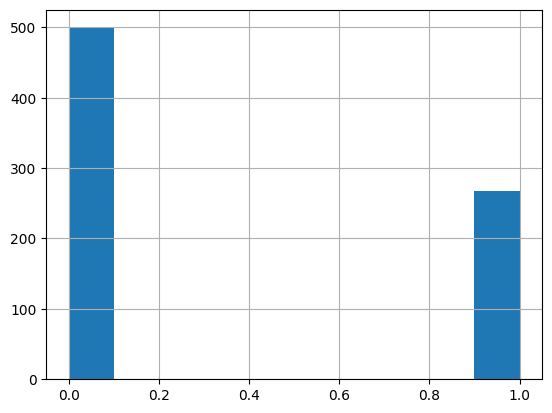

In [118]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [119]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

print(f"Обучающая-обучающая: {X_train.shape}, Обучающая-валидационная: {X_val.shape}, Тестовая: {X_test.shape}")

Обучающая-обучающая: (375, 8), Обучающая-валидационная: (162, 8), Тестовая: (231, 8)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [120]:
from sklearn.metrics import f1_score

max_depths = [3, 5, 7, 10, None]
min_samples_leafs = [1, 2, 5, 10]

best_f1 = 0
best_params = None

for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_params = (max_depth, min_samples_leaf)

clf = DecisionTreeClassifier(max_depth=best_params[0], min_samples_leaf=best_params[1], random_state=42)
clf.fit(X_train_full, y_train_full)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Best params: max_depth={best_params[0]}, min_samples_leaf={best_params[1]}")
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, AUC ROC: {roc_auc:.2f}")
print(f"F1:{best_f1:.2f}")

Best params: max_depth=5, min_samples_leaf=5
Accuracy: 0.77, Precision: 0.71, Recall: 0.56, AUC ROC: 0.72
F1:0.67


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [121]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42
)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Bagging - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, AUC ROC: {roc_auc:.2f}")

Bagging - Accuracy: 0.73, Precision: 0.63, Recall: 0.55, AUC ROC: 0.69


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [122]:
from sklearn.model_selection import cross_val_score

max_depths = [3, 5, 7, 9, None]
min_samples_splits = [2, 5, 10]

best_f1 = 0
best_params = None

for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )
        scores = cross_val_score(rf, X_train_full, y_train_full, cv=5, scoring='f1')
        mean_f1 = np.mean(scores)
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_params = (max_depth, min_samples_split)


rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params[0],
    min_samples_split=best_params[1],
    random_state=42
)
rf.fit(X_train_full, y_train_full)
y_pred = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
roc_auc_rf = roc_auc_score(y_test, y_pred)

print(f"Лучшие параметры : max_depth={best_params[0]}, min_samples_split={best_params[1]}")
print(f"Accuracy: {accuracy_rf:.2f}, Precision: {precision_rf:.2f}, Recall: {recall_rf:.2f}, AUC ROC: {roc_auc_rf:.2f}")
print(f"Средняя F1 на кросс-валидации: {best_f1:.2f}")

Лучшие параметры : max_depth=9, min_samples_split=2
Accuracy: 0.74, Precision: 0.62, Recall: 0.62, AUC ROC: 0.71
Средняя F1 на кросс-валидации: 0.64


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

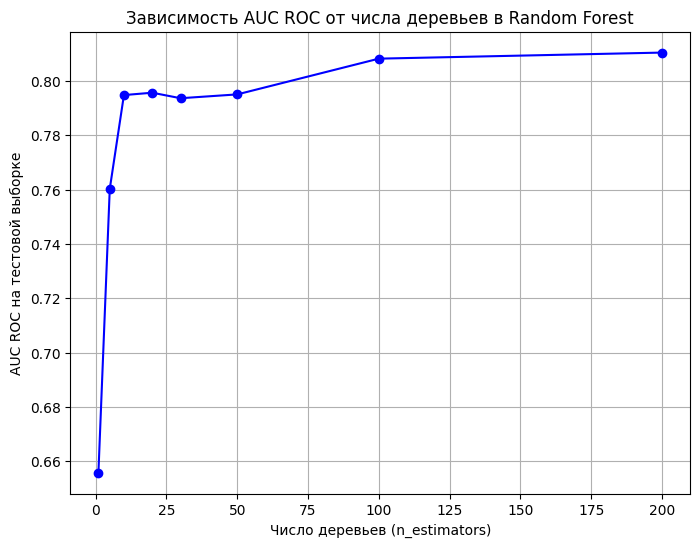

In [123]:
n_estimators_range = [1, 5, 10, 20, 30, 50, 100, 200]

auc_scores = []

for n in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=9,
        min_samples_split=2,
        random_state=42
    )
    rf.fit(X_train_full, y_train_full)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)

plt.figure(figsize=(8, 6))
plt.plot(n_estimators_range, auc_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Число деревьев (n_estimators)')
plt.ylabel('AUC ROC на тестовой выборке')
plt.title('Зависимость AUC ROC от числа деревьев в Random Forest')
plt.grid(True)
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

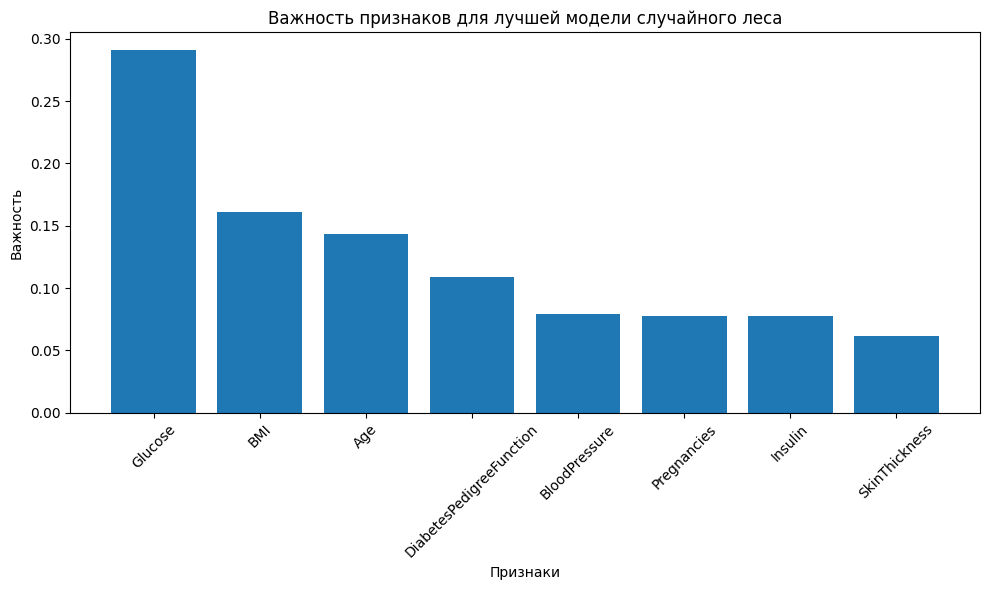

In [124]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=9,
    min_samples_split=2,
    random_state=42
)
rf.fit(X_train_full, y_train_full)

feature_importances = rf.feature_importances_
feature_names = X_train_full.columns

indices = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = feature_importances[indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Важность признаков для лучшей модели случайного леса')
plt.xticks(rotation=45)
plt.tight_layout()

Самый важным признаком стал Glucose.